In [ ]:
import zipfile
import os

# Path to the ZIP file
zip_path = "C:\\Users\\sarav\\Downloads\\archive (8).zip"  # Change this to your ZIP file path
extract_path = "extracted_files/"  # Folder where files will be extracted

# Create the directory if it doesn’t exist
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete! ✅")

Extraction complete! ✅


In [ ]:
import pandas as pd

# Load metadata CSV
df = pd.read_csv("sample\sample_labels.csv")
df


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


In [24]:
# Get minimum available samples for any disease class
min_samples = min(df["Finding Labels"].value_counts().min(), 2000)

# Sample the minimum available samples per disease
balanced_df = df.groupby("Finding Labels").apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)


C:\Users\sarav\AppData\Local\Temp\ipykernel_19312\1871003384.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby("Finding Labels").apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)


In [ ]:
import cv2
input_dir = "./"  
output_dir = "processed_images/"  
os.makedirs(output_dir, exist_ok=True)

for img_name in balanced_df["Image Index"]:
    img_path = os.path.join(input_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is not None:
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        cv2.imwrite(os.path.join(output_dir, img_name), img, [cv2.IMWRITE_JPEG_QUALITY, 50])  # Compress


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=balanced_df,
    directory="processed_images/",
    x_col="Image Index",
    y_col="Finding Labels",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=balanced_df,
    directory="processed_images/",
    x_col="Image Index",
    y_col="Finding Labels",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


Found 196 validated image filenames belonging to 244 classes.
Found 48 validated image filenames belonging to 244 classes.


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split labels
balanced_df["Finding Labels"] = balanced_df["Finding Labels"].apply(lambda x: x.split('|'))

# Convert to one-hot encoding
mlb = MultiLabelBinarizer()
one_hot_labels = mlb.fit_transform(balanced_df["Finding Labels"])
one_hot_df = pd.DataFrame(one_hot_labels, columns=mlb.classes_)
final_df = pd.concat([balanced_df["Image Index"], one_hot_df], axis=1)

# Save to CSV
final_df.to_csv("preprocessed_labels.csv", index=False)


In [ ]:
# Define the augmentation 
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)
image_files = [f for f in os.listdir(input_dir) if f.endswith((".jpg", ".png", ".jpeg"))]

In [ ]:
import numpy as np
augmented_dir = "augmented_images/"
os.makedirs(augmented_dir, exist_ok=True)

for img_name in image_files:
    img_path = os.path.join(input_dir, img_name)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=-1)  
    img = np.expand_dims(img, axis=0)  
    aug_iter = datagen.flow(img, batch_size=1)

    for i in range(5):
        aug_img = next(aug_iter)[0] 
        aug_img = (aug_img * 255).astype(np.uint8)
        
        aug_img_path = os.path.join(augmented_dir, f"aug_{i}_{img_name}")
        cv2.imwrite(aug_img_path, aug_img)


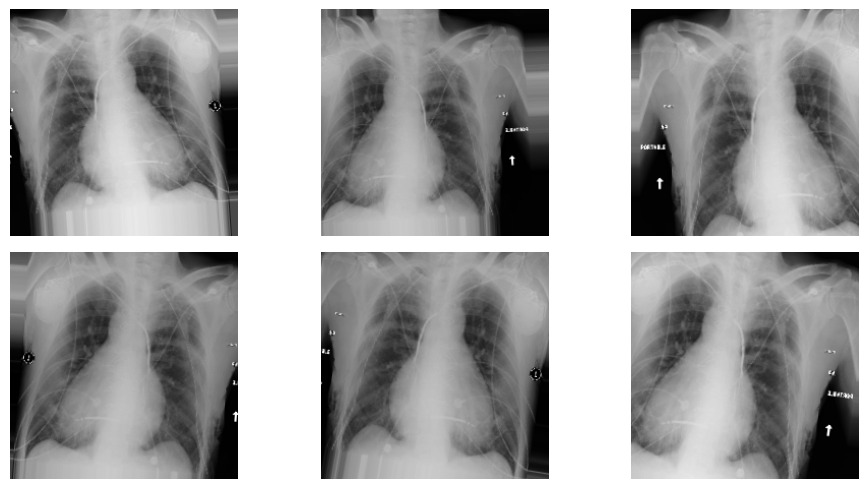

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Augmentation setup
# train_datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2],
#     fill_mode="nearest"
# )

img_path = r"processed_images\00000013_026.png"
img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)

aug_iter = train_datagen.flow(img, batch_size=1)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    batch = next(aug_iter)[0].astype('uint8')
    plt.imshow(batch.squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
